# TKT4108 Structural Dynamics 2

## Solution exercise 9

**Main topics:**  Periodic sampling, sample rates, frequency-domain filters

**References:** Github examples, lecture notes

### Problem 1: Technical terms

**a**) 

The Nyquist frequency is equal to half the sampling rate ($f_s/2$) and represents the highest frequency that can be accurately captured in data acquisition. In structural dynamics, the sampling rate must be at least twice the highest frequency of interest.

**b**)

Aliasing occurs when a signal is undersampled (meaning there are frequencies above the Nyquist frequency). These high-frequency components falsely appear as lower frequencies.


### Problem 2: Sampling rate of a measurement system

**a**)
The natural frequencies for a simply supported beam are $\omega_n= (n\pi)^2 \sqrt{ \dfrac{EI}{mL^4} } (n=1,2,3)$, while for the cantilever they are 
$\omega_n=\beta_n^2 \sqrt{ \dfrac{EI}{mL^4} }$, where $\beta_1=1.875$, $\beta_2=4.694$, and $\beta_3=7.855$.

The HEA200 beam weighs $42.3$ kg/m. The total mass per unit length is therefore $m=62.3$ kg/m. 

The second moment of area is $I=13.4 \cdot 10^6$ mm$^4$ $=13.4 \cdot 10^{-6}$ m$^4$ for the weak axis.

For steel, $E=210 \cdot 10^3$ MPa $=210 \cdot 10^{9}$ N/m$^2$.

The natural frequencies for the simply supported beam are $\omega_1=58$, $\omega_2=233$, and $\omega_3=524$ rad/s. For the cantilever beam they are $\omega_1=46$, $\omega_2=292$, and $\omega_3=814$ rad/s. We conclude that the highest frequency of interest is $814$ rad/s or $130$ Hz.

**b**)

In order to capture the dynamic content at $130$ Hz, the sample rate needs to be *at least* two times this, meaning $f_s=260$ Hz. This is a theoretical limit given by the Nyquist-Shannon sampling theorem, and there are other practical reasons why a substantially higher sample rate should be used:

- *i)* It is important to capture not only the resonance frequency of the highest mode but also the behaviour beyond it (consider the width of the peaks in the frequency response function).

- *ii)* There may be uncertainties in the actual frequencies of the system, which could be higher than anticipated. A higher sampling rate accounts for these variations. 

- *iii)* Operating near the Nyquist frequency $ f_s/2 $ can introduce errors due to the influence of anti-aliasing filters (low-pass filters) that are built into many measurement systems.  The anti-aliasing filters don't have a sharp cutoff at the Nyquist frequency but a gradual roll-off, which makes it generally undesirable to rely on data near this limit.

- *iv)* A low sampling rate means that there are very few data points per vibration cycle, so the plotted time series could be hard to interpret (even though the frequency information is still preserved).

We would typically prefer $f_s$ to be $\sim 1000$ Hz or greater.


### Problem 3: Low-pass filters

**a**)

The cutoff frequency defines the limit where the Butterworth filter starts to reduce the signal. For a low-pass filter, frequencies above the cutoff are progressively reduced. The cutoff frequency has different definitions, but can be specified as the frequency threshold where 95% (or some other fraction, like $1/\sqrt{2}$) of the amplitude is removed.


The filter order determines the steepness of the transition between the passband (frequency range which is kept) and the stopband (frequency range which is removed). A higher order leads to a steeper roll-off.

**b)**

The application of a low-pass filter leads to phase distortions. The "filtfilt" approach removes phase distortions introduced by a forward-only filter.


### Problem 4: Experiments of free decay in a structure

**a**)

The impulse load will excite multiple modes in the structure. The signal therefore contains the simultaneous free vibration of more than one mode, so no clear exponential decay is observed.

The structure can experience a small amount of stochastic excitation from background sources such as wind or vibrations transmitted through the ground. Therefore, additional vibrations occur in the structure before, during, and after the impact test, which are visible in the time series.

Measurement noise can also be a problem if the vibrations are small compared to the noise level of the sensor.

**b)**


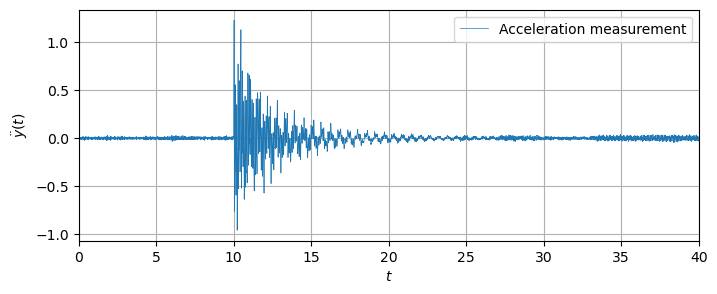

In [11]:
# Import and plot time series

import numpy as np
from matplotlib import pyplot as plt

# Load data from text file
data=np.loadtxt('acc_free_decay_test.txt',delimiter=',',skiprows=1).T

t=data[0,:] # Time vector
yddot=data[1,:] # Acceleration vector

plt.figure(figsize=(8,3))
plt.plot(t,yddot,label='Acceleration measurement',linewidth=0.5)
plt.xlabel("$t$")
plt.ylabel("$\ddot{y}(t)$")
plt.xlim(0,t[-1])
plt.legend()
plt.grid()


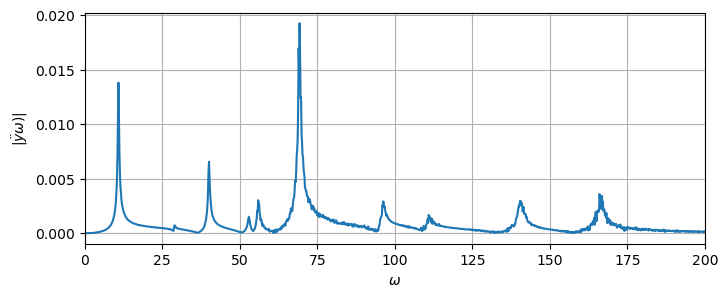

In [12]:
N=len(yddot)
    
dt=t[1]-t[0]

yddot_fft = np.fft.fftshift(np.fft.fft(yddot))/N # DFT

f_fft = np.fft.fftshift(np.fft.fftfreq(N, d=dt)) # Frequency axis in Hz
omega_fft=f_fft*2*np.pi # Convert to rad/s

plt.figure(figsize=(8,3))
plt.plot(omega_fft,np.abs(yddot_fft))
plt.ylabel('$|\ddot{y}{\omega})|$')
plt.xlabel('$\omega$')
plt.xlim(0,200)
plt.grid()

We see that at least 9 modes of the bridge are excited. From this FFT, it is clear that most of what is seen in the time series does not originate from mode 1. 

Mode 1 has a natural frequency of approximately 11 rad/s or 1.7 Hz. Mode 2 has a natural frequency of about 40 rad/s or 6.3 Hz. 

**c**)

If we select $\omega_c=20$, we can filter out most of the unwanted frequency components whilst keeping mode 1.

An order $n=6$ seems sufficient, although we could also use a higher order.

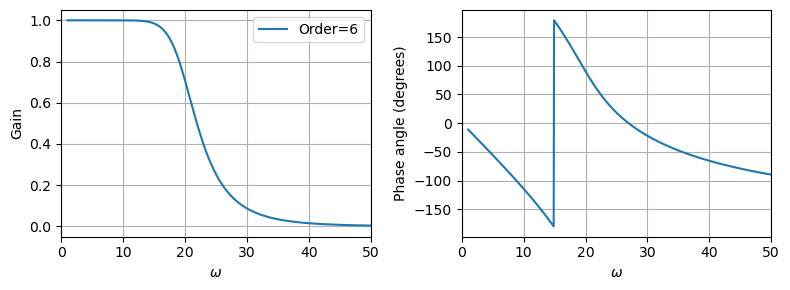

In [13]:
from scipy import signal as spsp

filter_order = 6
omega_cutoff = 20

# Plot filter frequency response function
b, a = spsp.butter(filter_order,omega_cutoff, analog=True) # Obtain the filter coefficients
omega_axis, frequency_response = spsp.freqs(b,a,worN = 1000) # Obtain frequency response function

fig, axs = plt.subplots(1,2,figsize=(8,3))

axs[0].plot(omega_axis,np.abs(frequency_response),label = 'Order=' + str(filter_order))
axs[1].plot(omega_axis,np.angle(frequency_response)*360/2/np.pi)
    
axs[0].legend()
axs[0].grid()
axs[0].set_xlim(0,50)
axs[0].set_ylabel('Gain')
axs[0].set_xlabel(r'$\omega$')

axs[1].grid()
axs[1].set_xlim(0,50)
axs[1].set_ylabel('Phase angle (degrees)')
axs[1].set_xlabel(r'$\omega$')

fig.tight_layout()
plt.show()

We observe that the signal is largely preserved at frequencies around 11 rad/s, while at approximately 40 rad/s, most of the content is effectively filtered out.

The filter phase shift is unavoidable but not a problem since we apply the filter twice using the filtfilt method, which compensates for phase distortion.

**d**)



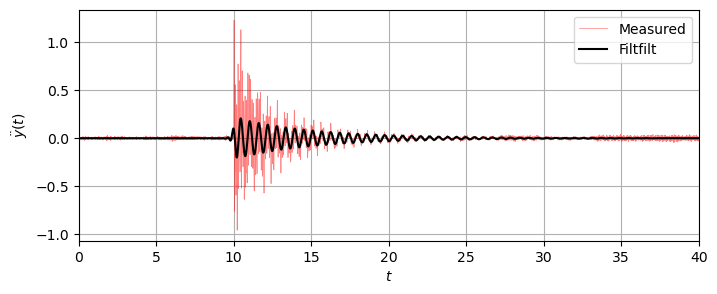

In [14]:
fs = 1/(t[1]-t[0]) # Sampling frequency in Hz

f_cutoff=omega_cutoff/(2*np.pi) # Cut-off frequency in Hz

sos = spsp.butter(filter_order,f_cutoff,"low", fs=fs, output='sos') # Cut-off must be given in Hz

yddot_filtfilt = spsp.sosfiltfilt(sos, yddot) # Filter signal

plt.figure(figsize=(8,3))
plt.plot(t,yddot,color='r',alpha=0.5,linewidth=0.5,label='Measured')
plt.plot(t,yddot_filtfilt,color='k',label = "Filtfilt")
plt.xlabel(r"$t$")
plt.ylabel("$\ddot{y}(t)$")
plt.grid()
plt.xlim(0,t[-1])
plt.legend()

By visual inspection the vibrations in the filtered signal are now dominated by the first natural frequency.

It is however not possible to split the signal into the components of free vibration and the background excitation.

**e**)

We zoom in on the free vibration part.


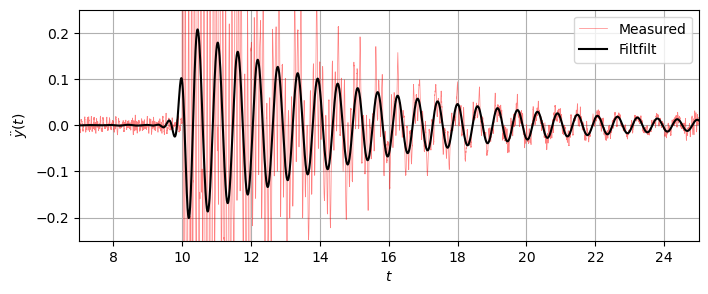

In [19]:
plt.figure(figsize=(8,3))
plt.plot(t,yddot,color='r',alpha=0.5,linewidth=0.5,label='Measured')
plt.plot(t,yddot_filtfilt,color='k',label = "Filtfilt")
plt.xlabel(r"$t$")
plt.ylabel("$\ddot{y}(t)$")
plt.xlim(7,25)
plt.ylim(-0.25,0.25)
plt.grid()
plt.legend()



We'll start with the tallest peak with a value of $\sim 0.2$. For the choice of the next peak, there is a trade-off:

- Using one cycle only leads to a larger uncertainty in the calculation of the logarithmic decrement.

- Using too many cycles can cause free vibration to be overshadowed by the ambient vibrations that don't fully decay to zero ($t>16$ s).

Therefore, we use the peak $n_{cyc}=6$ cycles later with a value of $\sim 0.1$. The damping ratio is estimated as follows:

$$
\xi= \dfrac{1}{2 \pi} \dfrac{1}{n_{cyc}} \log \left( \dfrac{ \ddot{y}(t)} {\ddot{y}(t+n_{cyc} T)} \right) =
\dfrac{1}{2 \pi} \dfrac{1}{6} \log \left( 0.2/0.1 \right)=0.0184
$$

which is $1.8$%. This is a slightly uncertain estimate since there is not a true free decay due to the additional background excitation.  
